In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd
import scipy
import time
import gurobipy as gp
from gurobipy import GRB

# Count Data

Datasets of count data for genes (rows) in cells (columns)

In [8]:
data_cast_concat = pd.read_csv("../Final_data/SS3_cast_UMIs_concat.csv", index_col="Unnamed: 0")
print(f"Size: {data_cast_concat.shape}")
data_cast_concat.head()

Size: (10727, 224)


,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,1.0,1.0,4.0,1.0,1.0,0.0,4.0,5.0,0.0,8.0,...,3.0,1.0,2.0,1.0,2.0,5.0,1.0,5.0,1.0,4.0
0610009B22Rik,0.0,0.0,NaN,NaN,2.0,9.0,0.0,2.0,8.0,3.0,...,6.0,0.0,0.0,2.0,7.0,2.0,0.0,0.0,0.0,6.0
0610009L18Rik,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009O20Rik,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,...,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [9]:
data_cast_mesc = pd.read_csv("../Final_data/SS3_cast_UMIs_mESC.csv", index_col="Unnamed: 0")
print(f"Size: {data_cast_mesc.shape}")
data_cast_mesc.head()

Size: (10927, 188)


,SS3_mESC_p1_A1_S1,SS3_mESC_p1_E1_S5,SS3_mESC_p1_C3_S19,SS3_mESC_p1_F2_S14,SS3_mESC_p1_A3_S17,SS3_mESC_p1_G2_S15,SS3_mESC_p1_G1_S7,SS3_mESC_p1_C1_S3,SS3_mESC_p1_B1_S2,SS3_mESC_p1_D2_S12,...,SS3_mESC_p2_E11_S85,SS3_mESC_p2_C11_S83,SS3_mESC_p2_C12_S91,SS3_mESC_p2_B12_S90,SS3_mESC_p2_D12_S92,SS3_mESC_p2_A12_S89,SS3_mESC_p2_G11_S87,SS3_mESC_p2_H11_S88,SS3_mESC_p2_E12_S93,SS3_mESC_p2_F12_S94
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,3.0,2.0,0.0,1.0,0.0,0.0,1.0,11.0,2.0,2.0,...,0.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
0610009B22Rik,2.0,1.0,5.0,3.0,0.0,0.0,0.0,1.0,2.0,3.0,...,8.0,3.0,5.0,9.0,2.0,0.0,4.0,2.0,0.0,0.0
0610009O20Rik,0.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
0610010F05Rik,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,3.0,0.0,0.0


In [10]:
data_c57_concat = pd.read_csv("../Final_data/SS3_c57_UMIs_concat.csv", index_col="Unnamed: 0")
print(f"Size: {data_c57_concat.shape}")
data_c57_concat.head()

Size: (10727, 224)


,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S18,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S1,SS3_MAF_Leo171129_p2_S20,...,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S186,SS3_MAF_leo180223_p4_S187,SS3_MAF_leo180223_p4_S191,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,0.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,7.0,2.0,...,1.0,3.0,0.0,1.0,2.0,9.0,4.0,0.0,0.0,0.0
0610009B22Rik,10.0,4.0,NaN,NaN,0.0,14.0,26.0,6.0,1.0,2.0,...,6.0,5.0,2.0,1.0,14.0,0.0,1.0,4.0,3.0,2.0
0610009L18Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
0610009O20Rik,3.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [11]:
data_c57_mesc = pd.read_csv("../Final_data/SS3_c57_UMIs_mESC.csv", index_col="Unnamed: 0")
print(f"Size: {data_c57_mesc.shape}")
data_c57_mesc.head()

Size: (10927, 94)


,SS3_mESC_p1_A1_S1,SS3_mESC_p1_E1_S5,SS3_mESC_p1_C3_S19,SS3_mESC_p1_F2_S14,SS3_mESC_p1_A3_S17,SS3_mESC_p1_G2_S15,SS3_mESC_p1_G1_S7,SS3_mESC_p1_C1_S3,SS3_mESC_p1_B1_S2,SS3_mESC_p1_D2_S12,...,SS3_mESC_p1_E11_S85,SS3_mESC_p1_F11_S86,SS3_mESC_p1_H11_S88,SS3_mESC_p1_A12_S89,SS3_mESC_p1_G11_S87,SS3_mESC_p1_C12_S91,SS3_mESC_p1_D12_S92,SS3_mESC_p1_B12_S90,SS3_mESC_p1_E12_S93,SS3_mESC_p1_F12_S94
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
0610007P14Rik,3.0,0.0,4.0,1.0,0.0,3.0,0.0,3.0,0.0,2.0,...,1.0,0.0,2.0,0.0,6.0,6.0,4.0,0.0,1.0,1.0
0610009B22Rik,2.0,5.0,0.0,1.0,7.0,0.0,0.0,3.0,0.0,3.0,...,1.0,0.0,4.0,7.0,4.0,0.0,0.0,0.0,3.0,0.0
0610009O20Rik,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,2.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0
0610010F05Rik,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,NaN,0.0,0.0,0.0


## Cleaning

Remove genes (rows) with mean expression < 1 (considering non-missing values): these are unlikely to have enough information for meaningful estimation, so are discarded to save computation time.

Additinally remove genes with a large proportion of missing values

In [12]:
# select rows with mean above 1
print(f"Old sizes: \n{data_cast_concat.shape} \n{data_cast_mesc.shape} \n{data_c57_concat.shape} \n{data_c57_mesc.shape}")
data_cast_concat = data_cast_concat.loc[data_cast_concat.mean(axis=1) > 1]
data_cast_mesc = data_cast_mesc.loc[data_cast_mesc.mean(axis=1) > 1]
data_c57_concat = data_c57_concat.loc[data_c57_concat.mean(axis=1) > 1]
data_c57_mesc = data_c57_mesc.loc[data_c57_mesc.mean(axis=1) > 1]
print(f"New sizes: \n{data_cast_concat.shape} \n{data_cast_mesc.shape} \n{data_c57_concat.shape} \n{data_c57_mesc.shape}")

Old sizes: 
(10727, 224) 
(10927, 188) 
(10727, 224) 
(10927, 94)
New sizes: 
(4264, 224) 
(3725, 188) 
(4226, 224) 
(3946, 94)


291 genes with > 25% missing values
286 genes with > 25% missing values
291 genes with > 25% missing values
311 genes with > 25% missing values


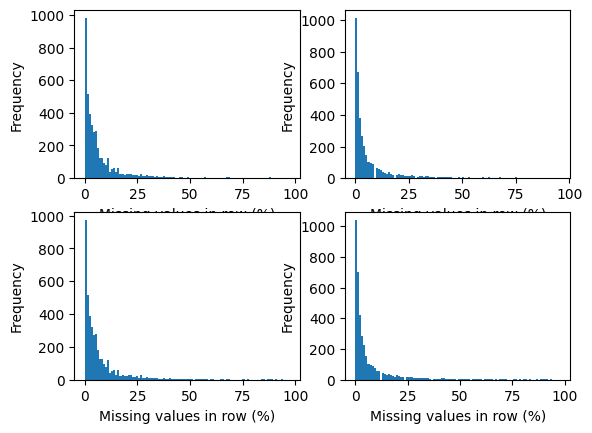

In [29]:
# find number / percentage of missing values per row
fix, ax = plt.subplots(2,2)
for i, data in enumerate([data_cast_concat, data_cast_mesc, data_c57_concat, data_c57_mesc]):
    num_missing = data.isna().sum(axis=1)
    per_missing = 100 * num_missing / data.shape[1]
    ax[i // 2, i % 2].hist(per_missing, bins=100);
    ax[i //2, i % 2].set_ylabel("Frequency")
    ax[i // 2, i % 2].set_xlabel("Missing values in row (%)")
    num = per_missing[per_missing > 25].count()
    print(f"{num} genes with > 25% missing values")

In [33]:
# remove genes with large proportion of missing values
data_cast_concat = data_cast_concat[100 * data_cast_concat.isna().sum(axis=1) / data_cast_concat.shape[1] < 25]
data_cast_mesc = data_cast_mesc[100 * data_cast_mesc.isna().sum(axis=1) / data_cast_mesc.shape[1] < 25]
data_c57_concat = data_c57_concat[100 * data_c57_concat.isna().sum(axis=1) / data_c57_concat.shape[1] < 25]
data_c57_mesc = data_c57_mesc[100 * data_c57_mesc.isna().sum(axis=1) / data_c57_mesc.shape[1] < 25]
print(f"New sizes: \n{data_cast_concat.shape} \n{data_cast_mesc.shape} \n{data_c57_concat.shape} \n{data_c57_mesc.shape}")

New sizes: 
(3963, 224) 
(3439, 188) 
(3924, 224) 
(3635, 94)


# E-MTAB-6362-raw-counts

Matrix of raw count data for ~25,000 genes in ~320 cells

In [2]:
data = pd.read_csv(r"..\New_data\E-MTAB-6362-raw-counts.csv", index_col="Unnamed: 0")
print(f"Size: {data.shape}")
data.head()

Size: (24826, 327)


,SAMEA104470620,SAMEA104470621,SAMEA104470622,SAMEA104470623,SAMEA104470624,SAMEA104470625,SAMEA104470626,SAMEA104470627,SAMEA104470628,SAMEA104470629,...,SAMEA104470946,SAMEA104470947,SAMEA104470948,SAMEA104470949,SAMEA104470950,SAMEA104470951,SAMEA104470952,SAMEA104470953,SAMEA104470954,SAMEA104470955
ENSMUSG00000000001,145.0,95.0,0.0,23.0,0.0,51.000000,145.00000,1.0,51.000000,1.0,...,303.00000,4.0,236.0,54.0,268.0,195.0,98.00000,174.0,247.0000,19.0
ENSMUSG00000000028,402.0,96.0,1.0,39.0,1.0,76.584206,170.10638,4.0,39.069515,0.0,...,487.00778,1.0,363.0,32.0,483.0,512.0,164.71356,299.0,864.0286,28.0
ENSMUSG00000000037,5.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,8.000000,0.0,...,174.00000,0.0,0.0,2.0,3.0,0.0,2.00000,0.0,14.0000,0.0
ENSMUSG00000000056,0.0,0.0,0.0,8.0,0.0,0.000000,16.00000,0.0,5.000000,0.0,...,42.00000,1.0,0.0,19.0,14.0,127.0,21.00000,31.0,69.0000,7.0
ENSMUSG00000000058,0.0,0.0,0.0,0.0,0.0,29.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0000,0.0


In [3]:
# select rows with mean above 1
data_2 = data.loc[data.mean(axis=1) > 1]
print(f"Size: {data_2.shape}")

Size: (14932, 327)


Text(0.5, 0, 'Zero values in row')

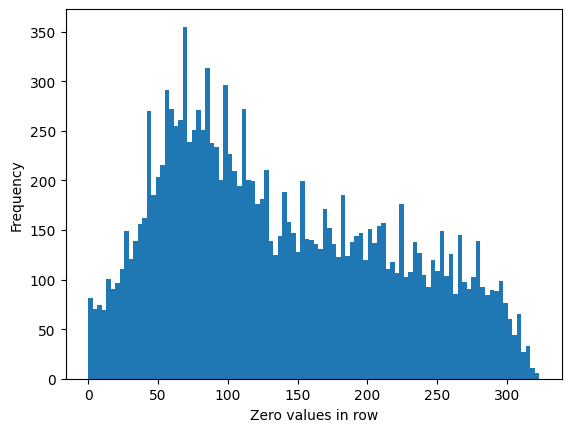

In [4]:
# find number of zero values per row (dropouts per gene)
num_missing = (data_2 == 0.0).sum(axis=1)
plt.hist(num_missing, bins=100);
plt.ylabel("Frequency")
plt.xlabel("Zero values in row")

In [5]:
((data_2 == 0.0).sum(axis=1) > 200).sum()

3827

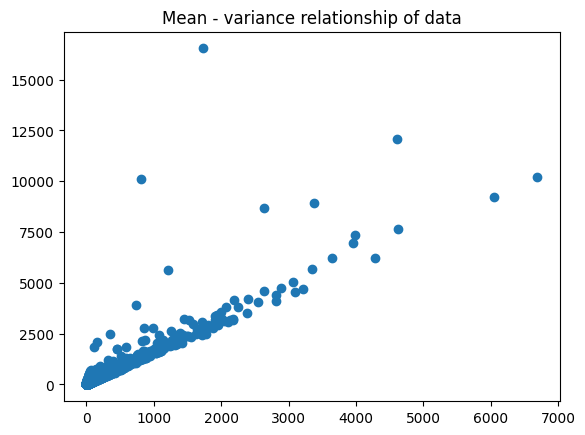

In [6]:
plt.scatter(data.mean(axis=1), data.std(axis=1))
plt.title("Mean - variance relationship of data")
plt.show()

(array([261.,  47.,  11.,   4.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([   0.    ,  340.0163,  680.0326, 1020.0489, 1360.0652, 1700.0815,
        2040.0978, 2380.1141, 2720.1304, 3060.1467, 3400.163 ]),
 <BarContainer object of 10 artists>)

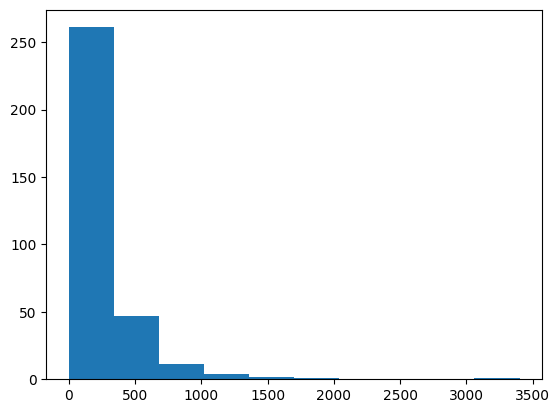

In [7]:
plt.hist(data_2.iloc[2000])

In [8]:
data_norm = pd.read_csv(r"..\New_data\E-MTAB-6362-normalised-counts.csv", index_col="Unnamed: 0")
print(f"Size: {data_norm.shape}")
data_norm.head()

Size: (24826, 327)


,SAMEA104470620,SAMEA104470621,SAMEA104470622,SAMEA104470623,SAMEA104470624,SAMEA104470625,SAMEA104470626,SAMEA104470627,SAMEA104470628,SAMEA104470629,...,SAMEA104470946,SAMEA104470947,SAMEA104470948,SAMEA104470949,SAMEA104470950,SAMEA104470951,SAMEA104470952,SAMEA104470953,SAMEA104470954,SAMEA104470955
ENSMUSG00000000001,47.002956,80.39816,0.00000,75.185520,0.00000,29.291403,76.253555,45.021896,85.668640,127.16174,...,42.430270,61.325233,76.17223,35.086468,61.029556,46.34809,67.234100,77.131165,29.981830,73.650260
ENSMUSG00000000028,130.311650,81.24446,328.83917,127.488480,101.57752,43.985466,89.456665,180.087590,65.628080,0.00000,...,68.197600,15.331308,117.16323,20.791980,109.989840,121.69345,113.003750,132.541470,104.879190,108.537230
ENSMUSG00000000037,1.620792,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,13.438218,0.00000,...,24.365898,0.000000,0.00000,1.299499,0.683167,0.00000,1.372124,0.000000,1.699375,0.000000
ENSMUSG00000000056,0.000000,0.00000,0.00000,26.151484,0.00000,0.000000,8.414186,0.000000,8.398887,0.00000,...,5.881424,15.331308,0.00000,12.345239,3.188111,30.18568,14.407307,13.741759,8.375491,27.134308
ENSMUSG00000000058,0.000000,0.00000,0.00000,0.000000,0.00000,16.655895,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


## Bootstrap

Rounds counts to nearest integers

Assumes no missing values (can deal with them)

In [36]:
def bootstrap_data_optim(samples, N, plot=False, printing=False, drop_missing=False):
    """
    Bootstrap sample data to find confidence intervals of
    stationary distribution values.

    Inputs:
    samples: sample from stationary distribution (counts of transcripts)
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's
    drop_missing: whether to drop missing values from the sample,
        or replace them with 0 (as used when preparing BayNorm data)

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """
    # change to series
    # samples = pd.Series(samples)

    # drop missing values
    if drop_missing:
        samples = samples.dropna()
    # replace with 0
    else:
        samples = samples.fillna(value=0.0)

    # change to int
    samples = samples.astype('int64')
    # maximum state observed
    x_max = int(np.nanmax(samples))
    # size of sample
    n = len(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    if printing or plot:
        for x in range(x_max + 1):
            if printing:
                print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
            if plot:
                plt.hist(counts[:, x] / n)
                plt.title(f"Hist of p({x})")
                plt.axvline(intervals[x][0], color="red")
                plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

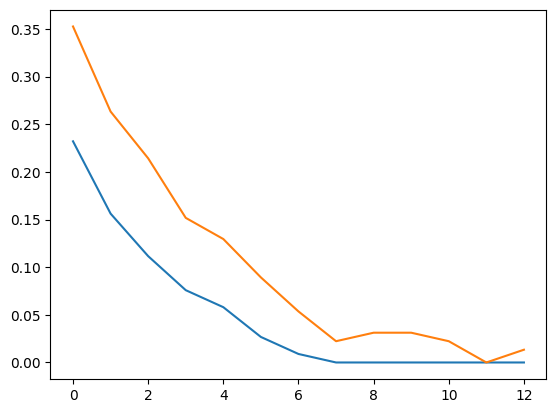

In [38]:
# select a sample from a gene (row of the dataset)
test_sample = data_cast_concat.iloc[0]

# bootstrap
test_intervals = bootstrap_data_optim(samples=test_sample, N=1000, plot=False, printing=False)

# plot resulting bounds
lb = [t_int[0] for t_int in test_intervals]
ub = [t_int[1] for t_int in test_intervals]
plt.plot(lb)
plt.plot(ub)

# Bursty Model

## LP bursty solver

In [11]:
def bursty_LP_optim(N, intervals, k0=None, k1=None, M=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    N: number of rows of Q / number of equations used
    M: maximum burst size to consider (>= 1)
    intervals: confidence intervals for at least N + 1 states

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # if max burst not specified: set to the largest burst that appears in Qp = 0 constraint
    if not M:
        M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # Construct the problem

    # Variables: specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable()
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = cv.Variable()
        k1_var = True
    else:
        k1_var = False
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    a = cv.Parameter()
    b = cv.Parameter()
    c = cv.Parameter(M)
    objective = a * k0 + b * k1 + c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # solve for k0 if variable
    if k0_var:
        var_name = 'k0'
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = [0 for i in range(M)]
        a.value = 1
        b.value = 0
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    else:
        solutions['k0'] = [k0]
    
    # solve for k1 if variable
    if k1_var:
        var_name = 'k1'
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = [0 for i in range(M)]
        a.value = 0
        b.value = 1
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    else:
        solutions['k1'] = [k1]

    # reset objective
    a.value = 0
    b.value = 0


    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


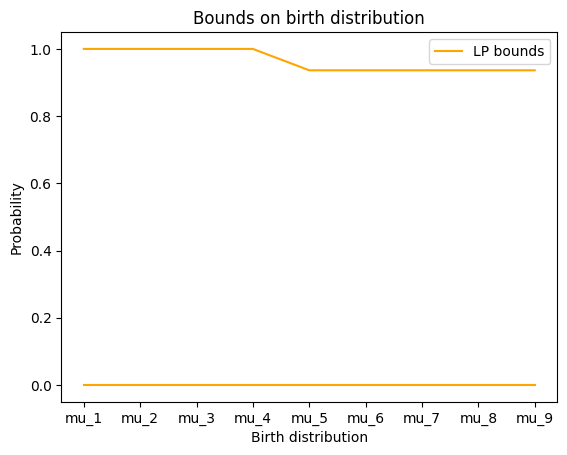

In [12]:
# solve
N = 10
M = N - 1
test_bounds = bursty_LP_optim(N, test_intervals, k0=1)

# extract and plot bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower_LP = [test_bounds[var][0] for var in labels]
upper_LP = [test_bounds[var][1] for var in labels]
plt.plot(labels, upper_LP, label = "LP bounds", color="orange")
plt.plot(labels, lower_LP, color="orange")
plt.title("Bounds on birth distribution")
plt.ylabel("Probability")
plt.xlabel("Birth distribution")
plt.legend()
plt.show()

## NLP bursty solver

In [13]:
def bursty_NLP(N, intervals, k0=None, k1=None, K=10, printing=False):
    """
    Solve bursty NLP system to get bounds on parameters

    Inputs:
    N: number of rows of Q / number of equations used
    intervals: CI's on at least N + 1 states
    k0: (optional) value of k0
    k1: (optional) value of k1
    K: prescribed max on kr variables in optimization (for computation)
    printing: whether to print solution information
    """
    # largest burst 1 less than N
    M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]
    
    # create model
    model = gp.Model("burst")

    # set options
    if not printing:
        model.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = model.addMVar(shape=N + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
    pis = model.addMVar(shape=M, vtype=GRB.CONTINUOUS, name="pis", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if not k0:
        k0 = model.addVar(vtype=GRB.CONTINUOUS, name="k0", lb=0, ub=K)
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = model.addVar(vtype=GRB.CONTINUOUS, name="k1", lb=0, ub=K)
        k1_var = True
    else:
        k0_var = False

    # Constraints:
    # Stationary condition: Qp = 0
    model.addConstr(k1*(Q1 @ p) + k0*(Q00 @ p) + gp.quicksum([k0*pis[m]*(Q0(m + 1) @ p) for m in range(0, M)]) == 0, name="Qp=0")
    # bounds
    model.addConstr(pl <= p, name="lb")
    model.addConstr(p <= pu, name="ub")
    # distributions
    model.addConstr(p.sum() <= 1, name="pdist")
    model.addConstr(pis.sum() <= 1, name="pidist")

    # solution dictionary
    solutions = {}

    # optimize for each variable in turn
    if k0_var:
        # minimize
        model.setObjective(k0, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k0'] = [min_val, max_val]
    else:
        solutions['k0'] = [k0]
    
    if k1_var:
        # minimize
        model.setObjective(k1, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k1'] = [min_val, max_val]
    else:
        solutions['k1'] = [k1]

    for m in range(0, M):
        # minimize
        model.setObjective(pis[m], GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(pis[m], GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions[f'mu_{m + 1}'] = [min_val, max_val]

    return solutions

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-10


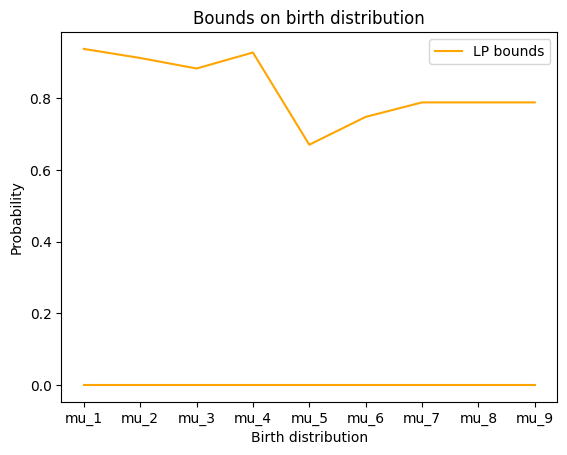

In [14]:
# solve 
N = 10
M = N - 1
test_bounds = bursty_NLP(N, test_intervals, k0=1)

# extract and plot bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower_NLP = [test_bounds[var][0] for var in labels]
upper_NLP = [test_bounds[var][1] for var in labels]
plt.plot(labels, upper_NLP, label = "LP bounds", color="orange")
plt.plot(labels, lower_NLP, color="orange")
plt.title("Bounds on birth distribution")
plt.ylabel("Probability")
plt.xlabel("Birth distribution")
plt.legend()
plt.show()

## Pipeline

- choose state space truncation
- solve LP and NLP

In [15]:
def bound_sample_refined(sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True):
    """
    Given transcript samples from gene, bootstrap and solve LP to bound parameters

    sample: list of counts of transcripts of gene in cells
    threshold: minimum number of occurances in sample needed to include state x
            set to zero to use up to max state available
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    N: option to manually specify number of equations used
    settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution
    """

    # find max burst size in sample
    x_max = int(np.nanmax(sample))

    # compute all possible bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)

    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    # find max state with more than threshold occurances
    x_max_thresh = x_max
    # look at all states: decreasing from max
    for x in range(x_max, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2

    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
     
    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max, color="red", label=f"Max state {x_max}")
        plt.axvline(x_max_thresh, color="red", label=f"Max threshold state {x_max_thresh}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()

    # get bounds on p(0), ..., p(x_max_thresh)
    # can use UP TO equation N = x_max, as involves up to p(x_max_thresh)
    # equation N involves pi's up to pi_(N-1), so M = N - 1
    if not N:
        N = x_max_thresh
    M = N - 1

    # solve LP using data
    if NLP:
        s = time.time()
        solutions_dist_NLP = bursty_NLP(N, intervals, k0=1, K=K, printing=False)
        print(f"NLP: {time.time() - s}")
    if LP:
        s = time.time()
        solutions_dist_LP = bursty_LP_optim(N, intervals, k0=1)
        e = time.time()
        print(f"LP: {e - s}")

    '''
    # check if infeasible
    while solutions_dist_NLP['mu_1'][0] is None:
        if print_status: print(f"N = {N} NLP infeasible")
        # stop if too few equations (cannot reduce any further leads to M = 0)
        if N <= skip + 1:
            break
        # try again with smaller N (drop 'skip' # of equations)
        N -= skip
        M -= skip
        solutions_dist_NLP = bursty_NLP(N, intervals, k0=1, K=K, printing=False)

    if print_status: print(f"N = {N} NLP feasible:")
    '''

    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        lower_NLP = [solutions_dist_NLP[var][0] for var in labels]
        upper_NLP = [solutions_dist_NLP[var][1] for var in labels]
        lower_LP = [solutions_dist_LP[var][0] for var in labels]
        upper_LP = [solutions_dist_LP[var][1] for var in labels]
        plt.plot(labels, upper_LP, label = "LP bounds", color="orange")
        plt.plot(labels, lower_LP, color="orange")
        plt.scatter(labels, upper_LP, color="orange")
        plt.scatter(labels, lower_LP, color="orange")
        plt.plot(labels, upper_NLP, label = "NLP bounds", color="blue")
        plt.plot(labels, lower_NLP, color="blue")
        plt.scatter(labels, upper_NLP, color="blue")
        plt.scatter(labels, lower_NLP, color="blue")
        plt.title("Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist_NLP, solutions_dist_LP

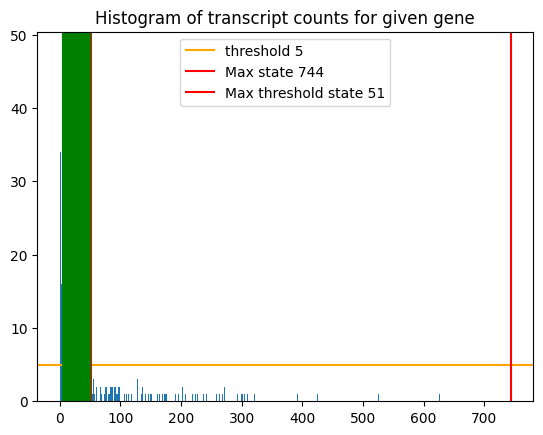

NLP: 292.3000831604004


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 13.490131139755249


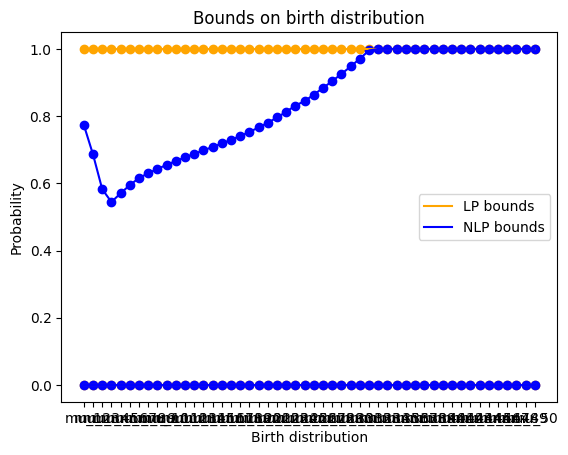

In [23]:
test_sample = data_2.iloc[0]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

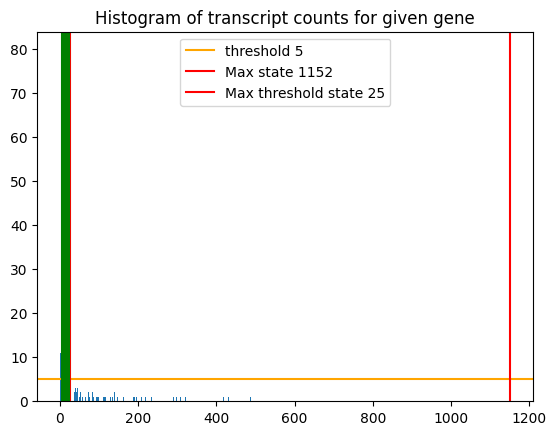

NLP: 23.980733633041382


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.2919201850891113


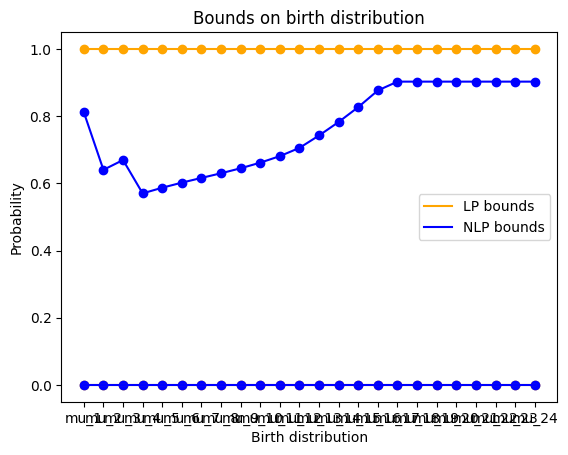

In [24]:
test_sample = data_2.iloc[1]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

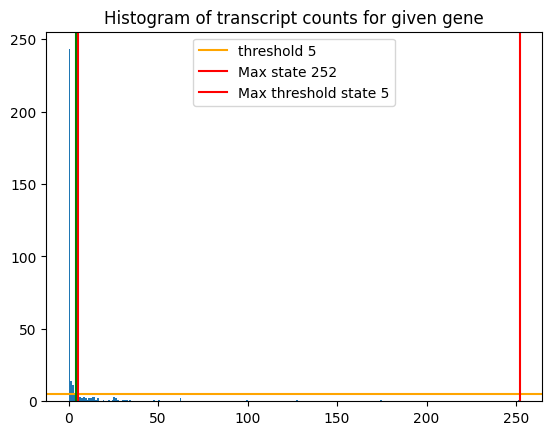

NLP: 0.017930984497070312
LP: 0.15971994400024414


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


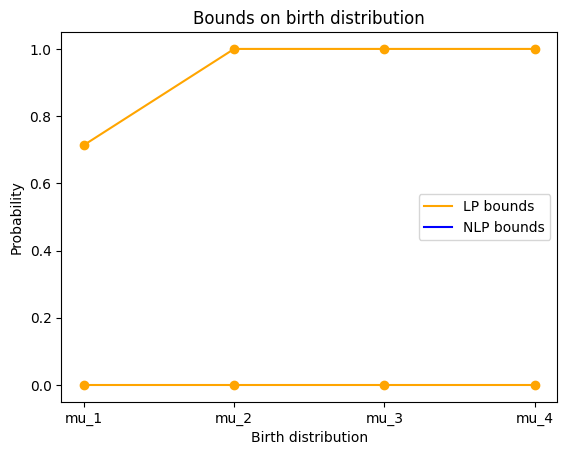

In [25]:
test_sample = data_2.iloc[2]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

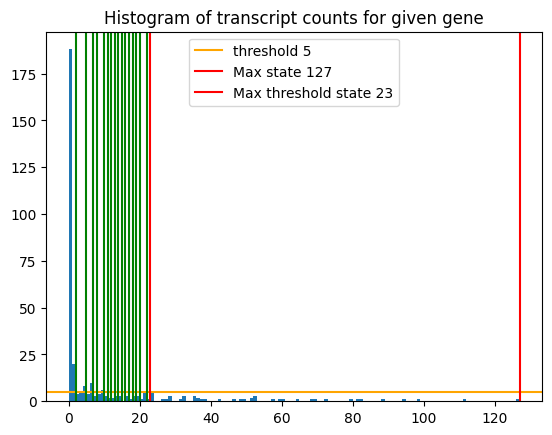

NLP: 16.286618947982788


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.9839468002319336


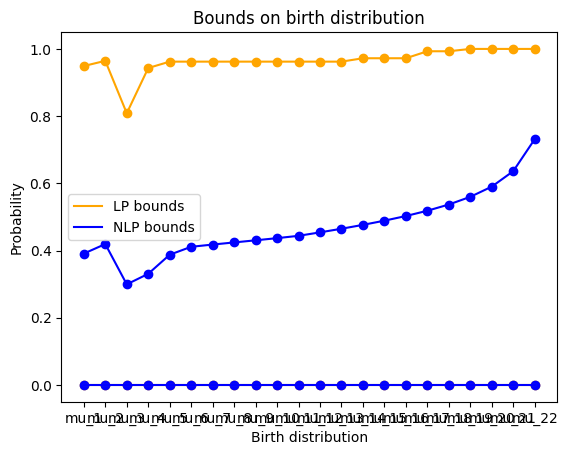

In [26]:
test_sample = data_2.iloc[3]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Edge case


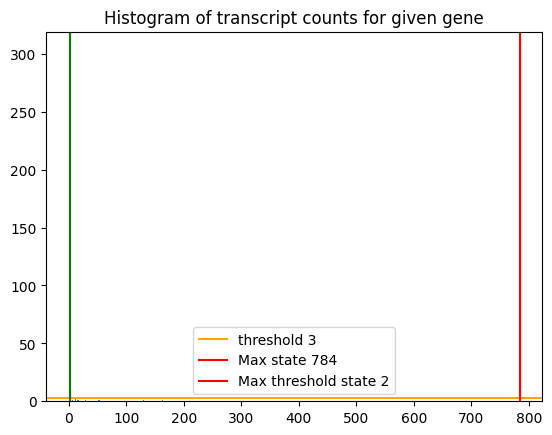

NLP: 0.0069773197174072266
LP: 0.04298567771911621


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


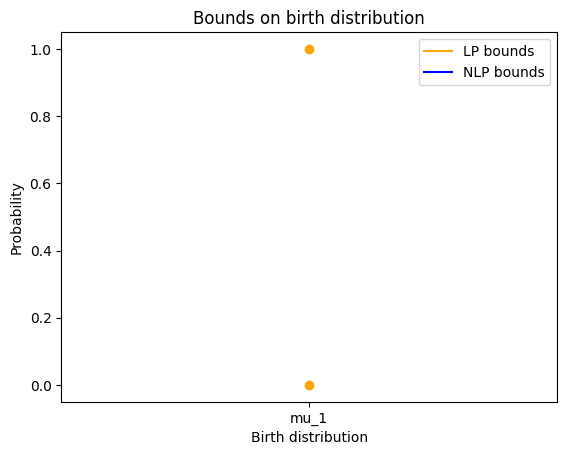

In [30]:
test_sample = data_2.iloc[4]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

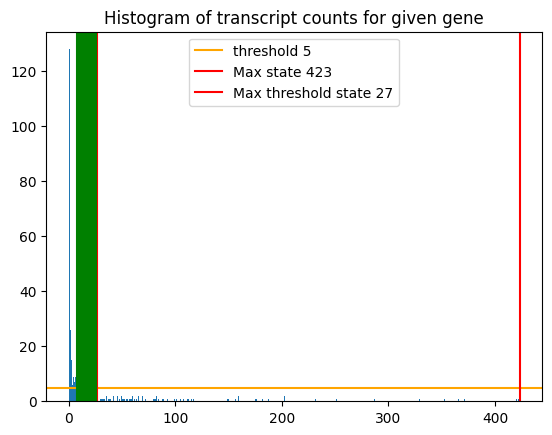

NLP: 1.3440451622009277


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.4098560810089111


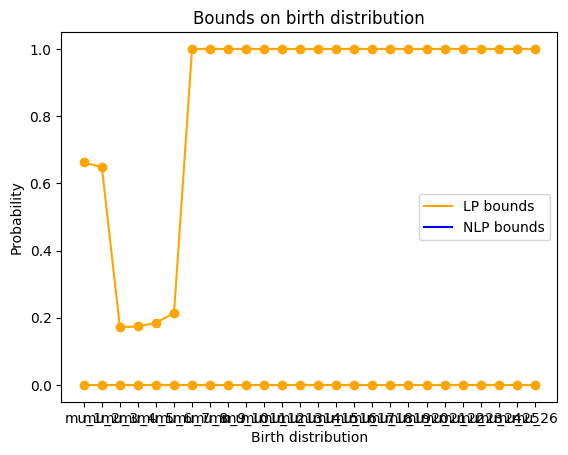

In [31]:
test_sample = data_2.iloc[5]
test_results = bound_sample_refined(test_sample, threshold=5, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

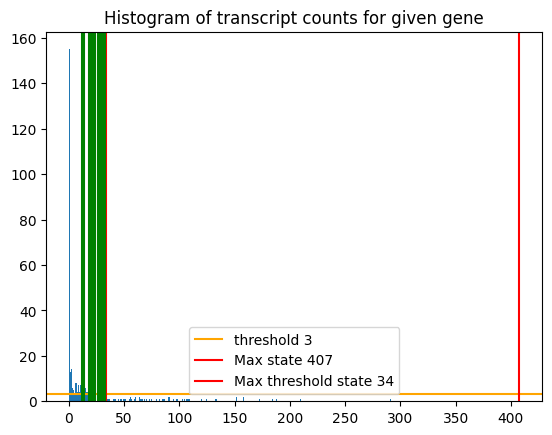

NLP: 38.85932636260986


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.95046329498291


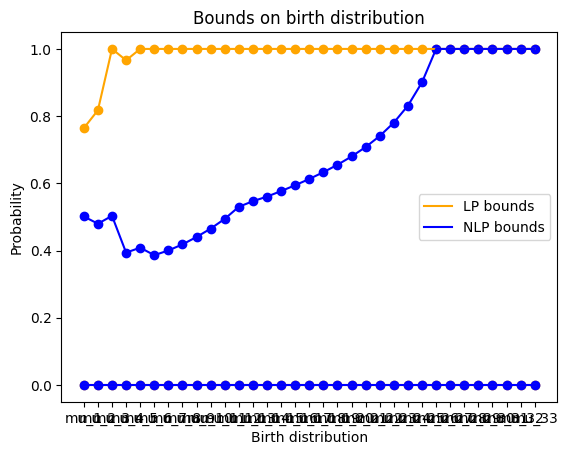

In [35]:
test_sample = data_2.iloc[6]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Gene 11595
Edge case


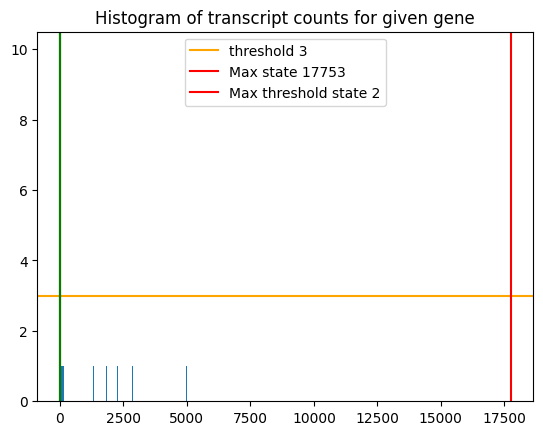

NLP: 0.12615680694580078
LP: 0.05749702453613281


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


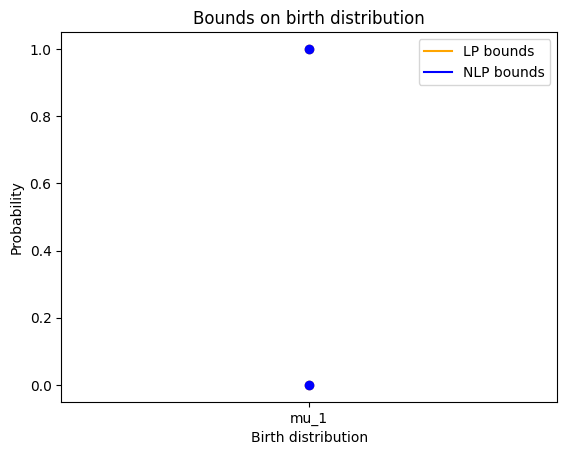

In [37]:
rng = np.random.default_rng(10)
idx = rng.choice(data_2.shape[0], 1)[0]
print(f"Gene {idx}")
test_sample = data_2.iloc[idx]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

Gene 1578


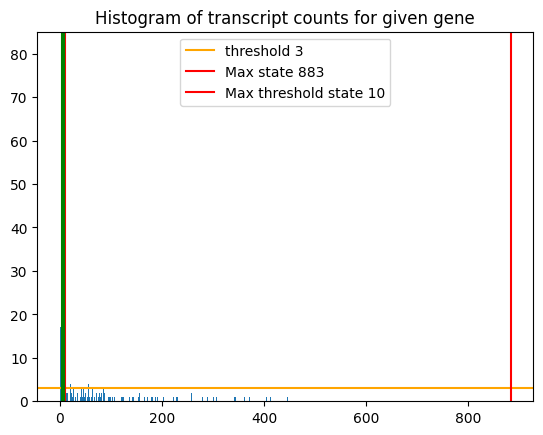

NLP: 0.4498302936553955
LP: 0.15455174446105957


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


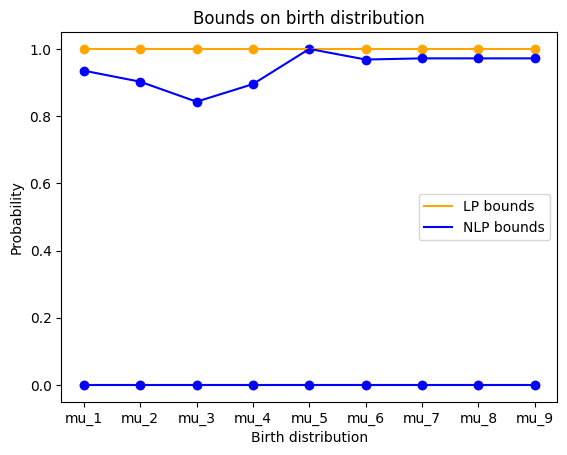

In [18]:
rng = np.random.default_rng(30)
idx = rng.choice(data_2.shape[0], 1)[0]
print(f"Gene {idx}")
test_sample = data_2.iloc[idx]
test_results = bound_sample_refined(test_sample, threshold=3, skip=1, n=1000, N=None, K=10,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)

## Analysis

In [59]:
# results dataframe
output_LP = pd.DataFrame()
output_NLP = pd.DataFrame()

In [60]:
for i in range(50):
    # select gene
    sample = data_2.iloc[i]
    # solve Bursty LP and NLP
    solution_NLP, solution_LP = bound_sample_refined(
                        sample, threshold=5, skip=1, n=1000, N=None, K=10,
                        plot_sample=False, print_bounds=False, 
                        print_status=False, plot_solution=False,
                        LP=True, NLP=True)
    # record
    df_solution_LP = pd.DataFrame([solution_LP])
    df_solution_NLP = pd.DataFrame([solution_NLP])
    output_LP = pd.concat([output_LP, df_solution_LP], ignore_index=True)
    output_NLP = pd.concat([output_NLP, df_solution_NLP], ignore_index=True)
    if (i % 100) == 0:
        print(f"{i}th entry analysed")

NLP: 207.20112323760986


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 10.242562055587769
0th entry analysed
NLP: 19.42944574356079


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.3373584747314453
NLP: 0.008970022201538086
LP: 0.08220767974853516


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 11.347580194473267


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.0689435005187988
Edge case
NLP: 0.01201319694519043
LP: 0.04091668128967285


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 1.4841556549072266


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.6606383323669434
NLP: 3.9215919971466064


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.46414709091186523
NLP: 0.11458086967468262
LP: 0.10351395606994629
NLP: 0.007175445556640625
LP: 0.060930490493774414
Edge case
NLP: 0.004984378814697266


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Pr

LP: 0.039335012435913086
NLP: 2.7286767959594727


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.4069838523864746
Edge case
NLP: 0.005978584289550781
LP: 0.04177284240722656
NLP: 0.017182588577270508


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.3481621742248535
NLP: 3.513131618499756


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.5076091289520264
NLP: 0.9023873805999756
LP: 0.2319505214691162


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 14.82846999168396


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.3765144348144531
NLP: 0.15101242065429688


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.13492846488952637
NLP: 12.860039949417114


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.1504545211791992
NLP: 6.647440195083618


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.4972653388977051
NLP: 0.005247354507446289
LP: 0.04480600357055664
NLP: 0.02828669548034668
LP: 0.05684781074523926


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 21.82179856300354


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.0444350242614746
NLP: 9.256630897521973


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.1377182006835938
NLP: 0.049431562423706055


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.0609889030456543
NLP: 0.013189315795898438
LP: 0.11819767951965332
Edge case
NLP: 0.0062100887298583984


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.040250301361083984
NLP: 0.15442848205566406
LP: 0.10124921798706055
NLP: 4.039187431335449


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.4922354221343994
NLP: 30.43247127532959


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.0612313747406006
NLP: 0.017158985137939453
LP: 0.041265010833740234


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 0.610987663269043


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.20208191871643066
NLP: 3.8617451190948486


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.5166840553283691
NLP: 0.018124103546142578
LP: 0.0661773681640625


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 10.661283731460571


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.9719321727752686
NLP: 0.8013789653778076
LP: 0.20751047134399414


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 8.360262393951416


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.8213508129119873
NLP: 0.24573945999145508
LP: 0.11561989784240723
NLP: 0.03730893135070801


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 1.0107388496398926
NLP: 8.06434440612793


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.9894397258758545
NLP: 0.007173061370849609
LP: 0.0655527114868164
Edge case
NLP: 0.0049686431884765625
LP: 0.04022216796875
NLP: 0.027332544326782227


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
c:\Users\willi\Documents\Year 4 Pr

LP: 0.05494236946105957
Edge case
NLP: 0.010166406631469727
LP: 0.043241024017333984


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 36.35434055328369


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 2.6275243759155273
NLP: 0.20117712020874023
LP: 0.10032868385314941


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


NLP: 0.5840260982513428


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.234968900680542
NLP: 2.6800572872161865


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.5368821620941162
NLP: 13.411427736282349


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 4.250107526779175
NLP: 3.8754353523254395


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.931971549987793
NLP: 3.1085920333862305


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.4925100803375244


In [62]:
output_LP.head()

,k0,k1,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,...,mu_41,mu_42,mu_43,mu_44,mu_45,mu_46,mu_47,mu_48,mu_49,mu_50
0,[1],"[0.7820652173913736, 2.541666666666729, optima...","[-3.392397270340161e-16, 0.9999999999999731, o...","[1.2443408597634964e-13, 0.9999999999998965, o...","[3.4407561117016893e-14, 0.9999999999974204, o...","[2.748877455908818e-14, 0.9999999999996624, op...","[2.2896011382842128e-14, 0.9999999999979566, o...","[1.9366761164933236e-14, 0.9999999999978753, o...","[1.610394782357922e-14, 0.9999999999998305, op...","[1.3054375465147525e-14, 0.9999999999965712, o...",...,"[-5.573651416745938e-15, 0.9999999999990629, o...","[-4.739570620156801e-15, 0.9999999999989485, o...","[-4.1389178102560045e-15, 0.9999999999990243, ...","[-3.672449429572722e-15, 0.9999999999994496, o...","[-3.3610462953186903e-15, 0.9999999999995547, ...","[-3.157391580459936e-15, 0.9999999999998387, o...","[-3.3759943230816333e-15, 0.9999999999999131, ...","[-3.567691779002931e-15, 0.9999999999979089, o...","[-3.708869106070344e-15, 0.9999999999982988, o...","[-3.8291099000129614e-15, 0.9999999999980866, ..."
1,[1],"[0.7291666666665882, 2.2692307692349933, optim...","[0.05606258148604405, 0.9999999999971096, opti...","[-5.839484454917414e-15, 0.9439374185099699, o...","[-5.1932790228573055e-15, 0.9439374185133782, ...","[-5.880923368230207e-15, 0.9439374185133474, o...","[-3.336252513364189e-14, 0.9439374185043679, o...","[-1.612510431919101e-15, 0.9439374185070352, o...","[-1.4336066300959019e-15, 0.9439374185075567, ...","[-4.148588622104615e-15, 0.9439374185090907, o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[1],"[10.3181818180783, 27.900000092865533, optimal...","[-7.17264572544337e-13, 0.7144573488194765, op...","[-4.649166789007853e-12, 0.9999999999996886, o...","[-3.7416025597648364e-12, 0.9999999999864041, ...","[-2.627191357676401e-12, 0.9999999999795982, o...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[1],"[5.8620689654948235, 13.292708334373751, optim...","[7.563830780962409e-16, 0.958792176493947, opt...","[4.3989852449446217e-16, 0.9745100810261209, o...","[5.274026991655028e-14, 0.8132748776510159, op...","[1.753273688867993e-16, 0.9528846154035812, op...","[1.742695727155486e-16, 0.9713070278239514, op...","[1.7677888310373015e-16, 0.9713070277968191, o...","[1.38657261996418e-16, 0.9713070277900534, opt...","[1.3284095645442951e-16, 0.9713070277829733, o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[1],"[9.218749963982656, inf, optimal, unbounded]","[1.2781944687606705e-10, 0.9999999999799267, o...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
def plot_dist(bounds, color="orange"):
    from ast import literal_eval
    # store
    labels = []
    lower = []
    upper = []
    # loop over dist
    for m in range(1, bounds.shape[0] - 1):
        bound = bounds[f"mu_{m}"]
        try:
            lower.append(bound[0])
            upper.append(bound[1])
            labels.append(f"mu_{m}")
        except:
            continue
    
    # plot
    plt.plot(labels, upper, label = "Solution bounds", color=color)
    plt.scatter(labels, upper, color=color)
    plt.plot(labels, lower, color=color)
    plt.scatter(labels, lower, color=color)
    plt.title("Bounds on birth distribution")
    plt.ylabel("Probability")
    plt.xlabel("Birth distribution")
    plt.legend()
    plt.show()

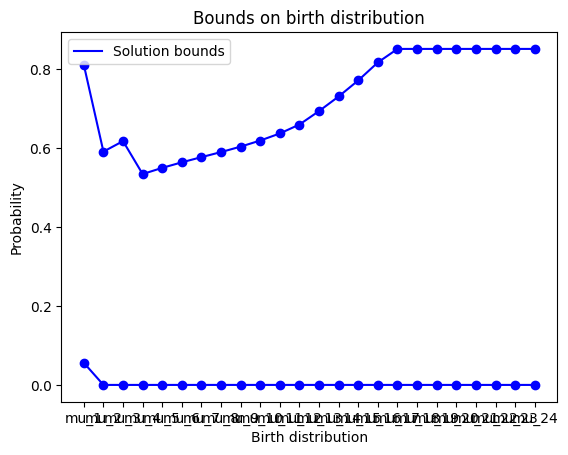

In [86]:
plot_dist(output_NLP.iloc[1], color="blue")

# B method

## Setup

### Load baynorm beta estimate

In [16]:
# List of Beta_j values for each cell j (named)
beta = pd.read_csv(r"..\New_data\E-MTAB-6362-raw-counts-BETA.csv", index_col="Unnamed: 0")
beta.head()

,x
SS3_MAF_Leo171129_p2_S10,0.056771
SS3_MAF_Leo171129_p2_S12,0.074493
SS3_MAF_Leo171129_p2_S13,0.068636
SS3_MAF_Leo171129_p2_S14,0.061267
SS3_MAF_Leo171129_p2_S16,0.059506


In [17]:
# List of Beta_j values for each cell j (named)
beta_ideal = pd.read_csv(r"..\New_data\E-MTAB-6362-raw-counts-BETA-ideal.csv", index_col="Unnamed: 0")
beta_ideal.head()

,x
SS3_MAF_Leo171129_p2_S10,0.473094
SS3_MAF_Leo171129_p2_S12,0.620779
SS3_MAF_Leo171129_p2_S13,0.571963
SS3_MAF_Leo171129_p2_S14,0.510559
SS3_MAF_Leo171129_p2_S16,0.495881


### B matrix

In [18]:
def B_matrix(beta, x_max, x_max_0):
    """
    Construct the binomial upscaling matrix B

    Arguments:
    beta: capture efficiencies for each cell
    x_max: observed truncation T = {0, ... , x_max}
    x_max_0: 'true' truncation T_0 = {0, ..., x_max_0}

    Returns:
    B: |T| x |T_0| upscaling matrix (x_max + 1, x_max_0 + 1)
    """
    if type(beta) == pd.core.frame.DataFrame:
        beta_list = list(beta['x'])
    elif type(beta) == float or type(beta) == int:
        beta_list = [beta]
    else:
        beta_list = np.array(beta)

    # initialise B
    B = np.zeros((x_max + 1, x_max_0 + 1))
    # loop over beta_j values
    for beta_j in beta_list:
        # create B_j matrix
        f = lambda x, x0: scipy.special.comb(x0, x) * beta_j**x * (1 - beta_j)**(x0 - x)
        B_j = np.fromfunction(f, (x_max + 1, x_max_0 + 1))
        # add to B
        B += B_j
    # scale B
    B = B / len(beta_list)
    return B

### Sample mean CI

In [19]:
def mean_CI(sample):
    '''Compute 95% confidence interval for the mean of the sample.'''
    # sample mean
    mean = np.mean(sample)
    # sample standard deviation
    std = np.std(sample)
    # size of the sample
    n = len(sample)
    # compute CI
    return (mean - 1.96 * (std / np.sqrt(n)), mean + 1.96 * (std / np.sqrt(n)))

## LP B solver

In [20]:
def bursty_LP_B(intervals, beta, x_max, x_max_0, mean_true_ub, k0=None, k1=None, M=None):
    """
    Solve the bursty LP system for interval bounds on parameters,
    upscaling observed data into true count data using B matrix

    Inputs:
    intervals: confidence intervals on observed count stationary distribution
    beta: capture efficiency/ies {allows single value or multiple as list/etc}
    x_max: use observed bounds p(0), ..., p(x_max)
    x_max_0: use upscaled bounds p(0), ..., p(x_max_0)
    mean_true_ub: upper bound on expected value of upscaled counts E[X^0]
    k0, k1: fixed values of parameters

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # observed bounds from CI
    pl_obs = [intr[0] for intr in intervals]
    pu_obs = [intr[1] for intr in intervals]

    # select observed bounds on p(0), ..., p(x_max)
    pl_obs = np.array(pl_obs)[:x_max + 1]
    pu_obs = np.array(pu_obs)[:x_max + 1]

    # compute upscaling B matrix
    B = B_matrix(beta, x_max, x_max_0)

    # number of equations N = x_max_0
    N = x_max_0

    # compute uppper bound on truncation error
    t_bound = mean_true_ub / (x_max_0 + 1)

    # estikmate up to largest burst size (unless otherwise specified)
    if not M:
        M = N - 1
    
    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # Construct the problem

    # Variables: unless k0 or k1 are fixed
    if not k0:
        k0 = cv.Variable()
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = cv.Variable()
        k1_var = True
    else:
        k1_var = False
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        # Qp = 0
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        # non-neg
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        # upscaled observed bounds
        k0 * pl_obs - k0 * t_bound <= B @ z0, B @ z0 <= k0 * pu_obs,
        k1 * pl_obs - k1 * t_bound <= B @ z1, B @ z1 <= k1 * pu_obs,
        # burst distribution constraints
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            # upscaled observed counts
            mu[m] * pl_obs - mu[m] * t_bound <= B @ y[:, m], B @ y[:, m] <= mu[m] * pu_obs,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # Objective
    a = cv.Parameter()
    b = cv.Parameter()
    c = cv.Parameter(M)
    objective = a * k0 + b * k1 + c @ mu
    objective_min = cv.Minimize(objective)
    objective_max = cv.Maximize(objective)

    # solution interval dict
    solutions = {}

    # values of c parameter: e_1, ..., e_M+2
    c_values = [[1 if i == j else 0 for j in range(M)] for i in range(M)]

    # create problem
    prob_min = cv.Problem(objective_min, constraints)
    prob_max = cv.Problem(objective_max, constraints)

    # solve for k0 if variable
    if k0_var:
        var_name = 'k0'
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = [0 for i in range(M)]
        a.value = 1
        b.value = 0
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    else:
        solutions['k0'] = [k0]
    
    # solve for k1 if variable
    if k1_var:
        var_name = 'k1'
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = [0 for i in range(M)]
        a.value = 0
        b.value = 1
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    else:
        solutions['k1'] = [k1]

    # reset objective
    a.value = 0
    b.value = 0

    # variable names
    var_names = [f"mu_{m + 1}" for m in range(M)]

    # repeatedly solve
    for i, c_val in enumerate(c_values):
        # variable
        var_name = var_names[i]
        solutions[var_name] = []
        # set parameter value (chooses variable in objective)
        c.value = c_val
        # solve min: add to solution
        result_min = prob_min.solve(warm_start=True, solver=cv.GUROBI)
        try:
            solutions[var_name].append(prob_min.value)
        except:
            solutions[var_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve(warm_start=True, solver=cv.GUROBI)
        try:
            solutions[var_name].append(prob_max.value)
        except:
            solutions[var_name].append(None)
        # add statuses
        solutions[var_name].append(prob_min.status)
        solutions[var_name].append(prob_max.status)
    
    return solutions

## NLP B solver

In [21]:
def bursty_NLP_B(intervals, beta, x_max, x_max_0, mean_true_ub, K=10, k0=None, k1=None, M=None, printing=True):
    """
    Solve the bursty NLP system for interval bounds on parameters,
    upscaling observed data into true count data using B matrix

    Inputs:
    intervals: confidence intervals on observed count stationary distribution
    beta: capture efficiency/ies {allows single value or multiple as list/etc}
    x_max: use observed bounds p(0), ..., p(x_max)
    x_max_0: use upscaled bounds p(0), ..., p(x_max_0)
    mean_true_ub: upper bound on expected value of upscaled counts E[X^0]
    k0, k1: fixed values of parameters

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # observed bounds from CI
    pl_obs = [intr[0] for intr in intervals]
    pu_obs = [intr[1] for intr in intervals]

    # select observed bounds on p(0), ..., p(x_max)
    pl_obs = np.array(pl_obs)[:x_max + 1]
    pu_obs = np.array(pu_obs)[:x_max + 1]

    # compute upscaling B matrix
    B = B_matrix(beta, x_max, x_max_0)

    # number of equations N = x_max_0
    N = x_max_0

    # compute uppper bound on truncation error: E[X^0]^U / (x_max_0 + 1)
    t_bound = mean_true_ub / (x_max_0 + 1)

    # estimate up to largest burst size (unless otherwise specified)
    if not M:
        M = N - 1
    
    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # create model
    model = gp.Model("burst_NLP")

    # set options
    if not printing:
        model.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = model.addMVar(shape=N + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
    pis = model.addMVar(shape=M, vtype=GRB.CONTINUOUS, name="pis", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if not k0:
        k0 = model.addVar(vtype=GRB.CONTINUOUS, name="k0", lb=0, ub=K)
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = model.addVar(vtype=GRB.CONTINUOUS, name="k1", lb=0, ub=K)
        k1_var = True
    else:
        k0_var = False

    # Constraints:
    # Stationary condition: Qp = 0
    model.addConstr(k1*(Q1 @ p) + k0*(Q00 @ p) + gp.quicksum([k0*pis[m]*(Q0(m + 1) @ p) for m in range(0, M)]) == 0, name="Qp=0")
    # bounds
    model.addConstr(pl_obs - t_bound <= B @ p, name="lb")
    model.addConstr(B @ p <= pu_obs, name="ub")
    # distributions
    model.addConstr(p.sum() <= 1, name="pdist")
    model.addConstr(pis.sum() <= 1, name="pidist")

    # solution dictionary
    solutions = {}

    # optimize for each variable in turn
    if k0_var:
        # minimize
        model.setObjective(k0, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k0'] = [min_val, max_val]
    else:
        solutions['k0'] = [k0]
    
    if k1_var:
        # minimize
        model.setObjective(k1, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k1'] = [min_val, max_val]
    else:
        solutions['k1'] = [k1]

    for m in range(0, M):
        # minimize
        model.setObjective(pis[m], GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(pis[m], GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions[f'mu_{m + 1}'] = [min_val, max_val]

    return solutions

## Pipeline

In [38]:
def bound_sample_refined_B(sample, beta, threshold=5, skip=1, n=1000, K=10,
                         a=1, x_max=None, x_max_0=None,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True):
    """
    Given transcript samples from gene, bootstrap and solve LP to bound parameters

    sample: list of up to ~200 counts of transcripts of gene in cells
    beta: estimated capture efficiency for each cell in the sample (or a single value)
    threshold: minimum number of occurances in sample needed to include state x
            set to zero to use up to max state available
    skip: number of equations to drop after an infeasible result
    n: number of bootstrap samples
    K: pre-set maximum value of k's
    a: parameter for x_max_0 heuristic
    x_max: option to manually specify trunction of observed states
    x_max_0: option to manually specify truncation of upscaled states
    settings:
    plot_sample: toggle histogram of sample
    print_bounds: toggle printing CI bounds
    print_status: toggle printing feasible/infeasible reports
    plot_solution: toggle plotting solution bounds on distribution
    """

    # compute all possible observed bounds: p(0), ... , p(x_max)
    intervals = bootstrap_data_optim(sample, n, printing=print_bounds)

    # compute upper bound on mean of observed sample E[X]
    mean_ob_ub = mean_CI(sample)[1]

    # calculate upper bound on mean of true sample E[X^0]
    mean_beta = np.mean(beta)
    mean_true_ub = mean_ob_ub / mean_beta

    # dict of states and occurances in sample
    counts = sample.value_counts().to_dict()

    """
    if x_max is None:
        # find the largest state s.t. it and all smaller have at least threshold occurances
        x_max = 0
        for x in range(0, x_max_obs):
            if x in counts and counts[x] >= threshold:
                x_max = x
            else:
                # state not observed, or fewer than threshold observations
                break
    """

    # potential for different x_max truncation method + using [0, 1] bound replacement

    # largest observed state
    x_max_obs = int(np.nanmax(sample))

    # find max state with more than threshold occurances
    x_max_thresh = x_max_obs
    # look at all states: decreasing from max
    for x in range(x_max_obs, -1, -1):
        if x in counts:
            # check for first state with >= threshold occurances
            if counts[x] >= threshold:
                # record state
                x_max_thresh = x
                break

    # edge case: need at least bounds up to p(2) to estimate pi_1
    if x_max_thresh < 2:
        print("Edge case")
        x_max_thresh = 2

    # for each state up to x_max_thesh:
    # above threshold # observations => use CI
    # below => use [0,1] bounds
    # track [0,1] bounded states
    non_bounds = []
    """
    for x in range(x_max_thresh + 1):
        if x in counts:
            # below
            if counts[x] < threshold:
                # [0,1] bounds
                intervals[x] = np.array([0.0, 1.0])
                non_bounds.append(x)
        # if not in count: 0 occurances, below threshold (unless = 0)
        elif threshold > 0:
            intervals[x] = np.array([0.0, 1.0])
            non_bounds.append(x)
    """

    # heuristic choice of x_max
    if x_max is None:
        x_max = x_max_thresh

    if x_max_0 is None:
        # heuristic choice of x_max_0
        x_max_0 = int(a * x_max // np.mean(beta))

    print(f"x_max = {x_max} \nx_max_0 = {x_max_0}")

    # plot sample hist and threshold
    if plot_sample:
        plt.hist(sample, bins=x_max_obs);
        plt.title("Histogram of transcript counts for given gene")
        plt.axhline(threshold, 0, 1, color="orange", label=f"threshold {threshold}")
        plt.axvline(x_max_obs, color="red", label=f"Max state {x_max_obs}")
        plt.axvline(x_max, color="red", label=f"Max threshold state {x_max}")
        for x in non_bounds:
            plt.axvline(x, color="green")
        plt.legend()
        plt.show()
    
    if NLP:
        x_max_0_nlp = x_max_0
        s = time.time()
        solutions_dist_NLP = bursty_NLP_B(intervals, beta, x_max, x_max_0_nlp, mean_true_ub, k0=1, K=K, printing=False)
        print(f"NLP: {time.time() - s}")
    else:
        solutions_dist_NLP = None
    if LP:
        s = time.time()
        solutions_dist_LP = bursty_LP_B(intervals, beta, x_max, x_max_0, mean_true_ub, k0=1)
        print(f"LP: {time.time() - s}")
    else:
        solutions_dist_LP = None

    # estimating pi_1, ..., pi_M
    M = x_max_0 - 1
    
    # plot
    if plot_solution:
        # extract distribution bounds
        labels = [f'mu_{m}' for m in range(1, M + 1)]
        if LP:
            lower_LP = [solutions_dist_LP[var][0] for var in labels]
            upper_LP = [solutions_dist_LP[var][1] for var in labels]
            plt.plot(labels, upper_LP, label = "LP bounds", color="orange")
            plt.plot(labels, lower_LP, color="orange")
        if NLP:
            labels_NLP = [f'mu_{m}' for m in range(1, x_max_0_nlp)]
            lower_NLP = [solutions_dist_NLP[var][0] for var in labels_NLP]
            upper_NLP = [solutions_dist_NLP[var][1] for var in labels_NLP]
            plt.plot(labels_NLP, upper_NLP, label = "NLP bounds", color="blue")
            plt.plot(labels_NLP, lower_NLP, color="blue")
        plt.title("Bounds on birth distribution")
        plt.ylabel("Probability")
        plt.xlabel("Birth distribution")
        plt.legend()
        plt.show()

    # return bounds
    return solutions_dist_NLP, solutions_dist_LP

x_max = 23 
x_max_0 = 191


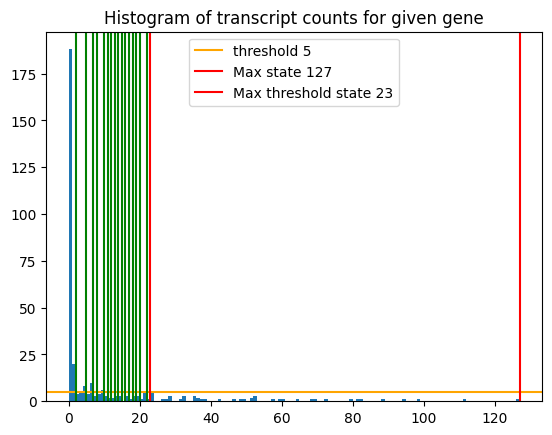

NLP: 347.6924583911896


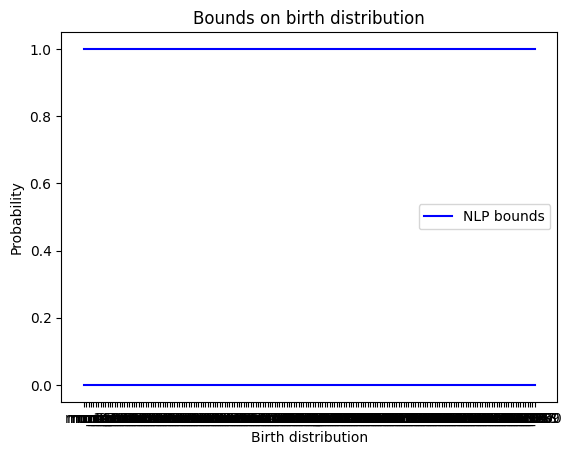

In [46]:
test_sample = data_2.iloc[3]
test_results = bound_sample_refined_B(test_sample, beta, threshold=5, skip=1, n=1000, K=10,
                         a=0.5, x_max=None, x_max_0=None,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=False, NLP=True)

x_max = 51 
x_max_0 = 425


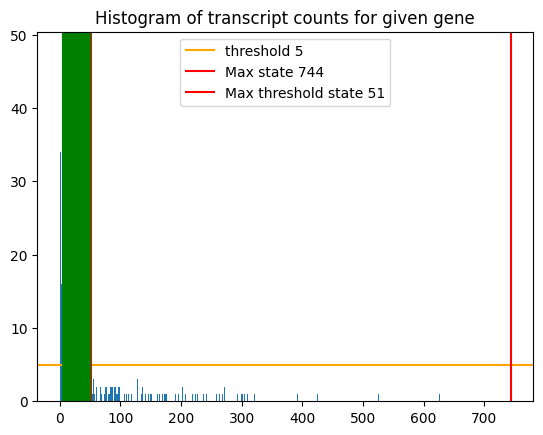

NLP: 2198.403246164322


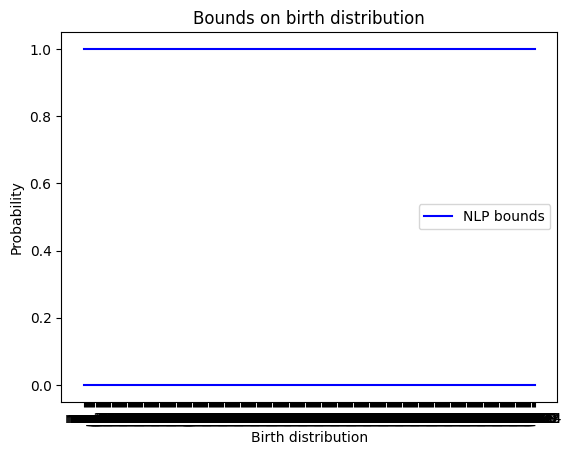

In [50]:
test_sample = data_2.iloc[0]
test_results = bound_sample_refined_B(test_sample, beta, threshold=5, skip=1, n=1000, K=10,
                         a=0.5, x_max=None, x_max_0=None,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=False, NLP=True)

x_max = 27 
x_max_0 = 55


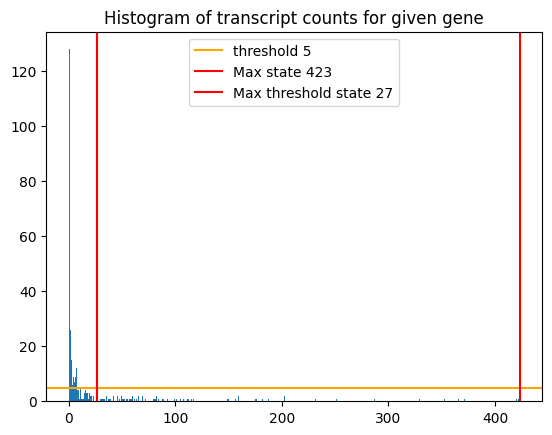

NLP: 1.2497365474700928


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 76.36142539978027


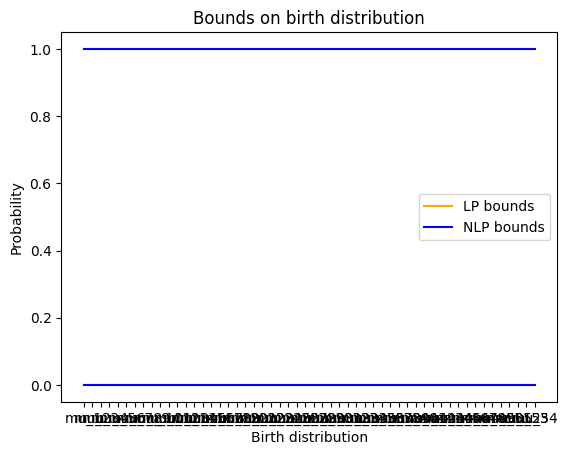

In [39]:
test_sample = data_2.iloc[5]
test_results = bound_sample_refined_B(test_sample, beta_ideal, threshold=5, skip=1, n=1000, K=10,
                         a=1, x_max=None, x_max_0=None,
                         plot_sample=True, print_bounds=False, 
                         print_status=True, plot_solution=True,
                         LP=True, NLP=True)